In [1]:
using ForwardDiff
using Plots
using SimpleSolvers

using ForwardDiff

using LinearAlgebra
using LogExpFunctions, Distances
using WassersteinDictionaries

using Optim, LineSearches
using Particles

In [82]:
const d = 2
const n = 32

L = 1
vmin = 0
vmax = 1

x₁ = collect(range(vmin,vmax,length=n))
x₂ = collect(range(0,L,length=n));

In [83]:
x_v = zeros(n^2,2)

for i1 in 1:n
    for i2 in 1:n
        x_v[(i1-1)*n + i2, 1] = x₁[i1]
        x_v[(i1-1)*n + i2, 2] = x₂[i2]
    end
end

In [84]:
t = 0:1:1
a = 0.5
ν = 0.00 #[ 10.0^(-s) for s in 3]

function _p(x,t,a,ν)
    x₀ = [0.25; 0.25] + t*a*[1; 1]
    σ = sqrt(0.002 + 2*t*ν)
    
    1/(2*pi*σ^2) * exp(-norm(x - x₀)^2/(2*σ^2))
end

Sₜ = length(t)*length(a)*length(ν)

2

In [85]:
p = [zeros(n,n) for _ in 1:Sₜ] # input histograms

for r in 1:length(ν)
    for s in 1:length(t)
        idx = s + (r-1)*length(t)
        for i in 1:n
            for j in 1:n
                p[idx][i,j] = _p([x₁[i]; x₂[j]], t[s], a, ν[r])
            end
        end
        p[idx] ./= sum(p[idx])
    end
end

p_v = [ vec(p[i]) for i in 1:Sₜ ];


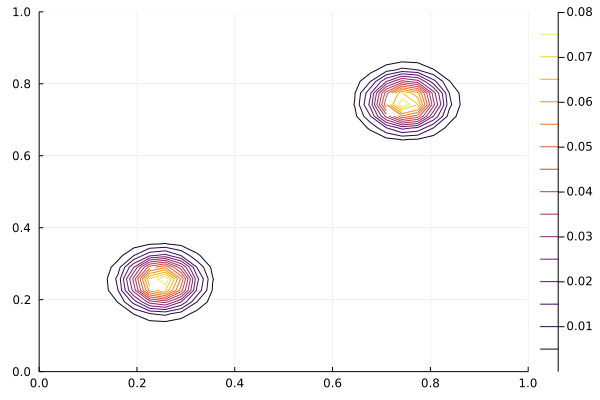

In [86]:
contour(x₁, x₂, p_v)

In [196]:
ε = 5e-3

SP = SinkhornParameters(32, ε)
SPB = SinkhornParameters(32, ε)

SP.averaged_updates = false
SP.debias = true

α = [ p_v[1], p_v[end] ]
α_indices = [ 1, Sₜ ]
S = 2

h_hyp = L/(vmax-vmin)
function _K(u,v)
    #0.5*(u[2] - v[2])^2 + 2/h_hyp^2 * ( u[1] - v[1] + 0.5*h_hyp*(u[2]+v[2]) )^2
    (u[2] - v[2])^2 + (u[1] + 0.1*u[2] - v[1])^2
end

caches = ( VVC = VectorVectorCache(S,n^2), VC = VectorCache(S,n^2) )

a₀ = ones(size(α[1])); b₀ = ones(size(α[1]))
d₀₁ = ones(size(α[1])); d₀₂ = ones(size(α[1]))

b_₀ = [ones(size(α[s])) for s in eachindex(α)] 
d₀ = ones(size(α[1]));

x_trace = []
y_trace = [];

In [197]:
K_lazy = exp.(-LazyCost(x_v, x_v, _K)./ε)
#K_lazy = exp.(-LazyCost(x_v, x_v)./ε)
K = zeros(n^2,n^2)
for i in 1:n^2
    for j in 1:n^2
        K[i,j] = K_lazy[i,j]
    end
end

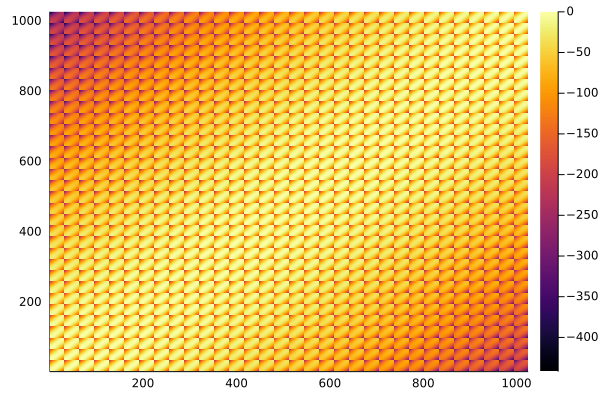

In [198]:
heatmap(log.(K))

In [199]:
sinkhorn_dvg(p_v[1], p_v[2], a₀, b₀, d₀₁, d₀₂, K, SP, caches)

0.47537736832771343

In [204]:
t = 0.99
μ = sinkhorn_barycenter([1-t,t], α, b_₀, d₀, K, SPB, caches);

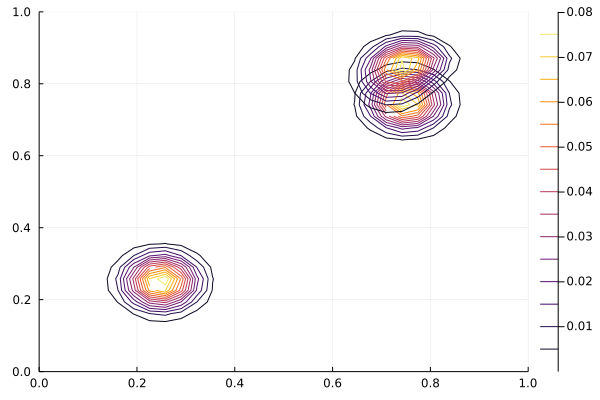

In [205]:
contour(x₁, x₂, [p_v, μ])

In [10]:
Δ = [ abs(sinkhorn_dvg(p_v[1], p_v[s], K, a₀, b₀, d₀₁, d₀₂, SP, caches)) for s in eachindex(p_v) ]

In [47]:
function optimcallback(x, loss)
    #SP.update_potentials = true
    #SPB.update_potentials = true

    push!(y_trace, loss(x[end].metadata["x"]) )
    push!(x_trace, softmax(x[end].metadata["x"]))

    SP.update_potentials = false
    SPB.update_potentials = false

    SP.L = 64
    SPB.L = 64

    return false
end

optimcallback (generic function with 1 method)

In [48]:


ΔW = zeros(Sₜ)
λ = [zeros(S) for _ in 1:Sₜ]

results = []



for s in 1:Sₜ

    q = p[s]

    a₀ .= 1; b₀ .= 1
    d₀₁ .= 1; d₀₂ .= 1

    for s_ in 1:S
        b_₀[s_] .= 1
    end
    d₀ .= 1

    function w2_loss_separated(w::Vector{T}) where T
        μ_λ = sinkhorn_barycenter_separated(softmax(w), α, b_₀, d₀, k, SPB, caches)
        return abs( sinkhorn_dvg_separated(μ_λ, q, a₀, b₀, d₀₁, d₀₂, k, SP, caches) ) #+ sqeuclidean(μ_λ,q)/norm(q)^2
    end

    SP.L = 64
    SPB.L = 64

    brk = false
    for s_α in eachindex(α_indices)
        if s == α_indices[s_α]
            λ[s][s_α] = 1
            ΔW[s] = 0.0
            brk = true
        end
    end

    if brk
        continue
    end

    result = optimize(  w2_loss_separated,
                        zeros(S),                     
                        LBFGS(  m=10, 
                                #linesearch = LineSearches.BackTracking( c_1=1e-6, iterations = 100),
                                #alphaguess = LineSearches.InitialStatic()
                            ),
                        Optim.Options(  callback = x -> optimcallback(x, w2_loss_separated),
                                        iterations = 32,
                                        allow_f_increases = true,
                                        store_trace = true,
                                        extended_trace = true,
                                        g_tol = 1e-5,
                                        f_tol = 1e-3),
                        autodiff=:forward   )

    push!(results, result)

    wₒₚₜ = Optim.minimizer(result)
    λ[s] = softmax(wₒₚₜ)
    ΔW[s] = Optim.minimum(result)
end


In [49]:
results[5]

 * Status: success

 * Candidate solution
    Final objective value:     1.203448e-10

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 1.0e-03
    |g(x)|                 = 5.00e-18 ≤ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    0
    f(x) calls:    1
    ∇f(x) calls:   1


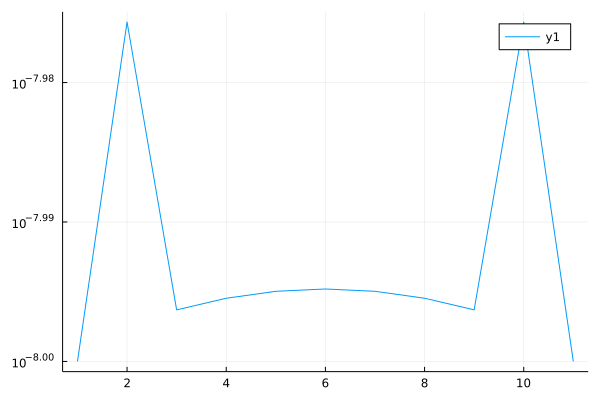

In [50]:
plot(ΔW .+ 1e-8, yaxis=:log)

In [51]:
λ

11-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [0.9000321894888104, 0.09996781051118955]
 [0.8000000480945926, 0.1999999519054074]
 [0.7000001696267169, 0.29999983037328304]
 [0.6000000003471504, 0.3999999996528497]
 [0.5, 0.5]
 [0.39999999965284955, 0.6000000003471504]
 [0.29999983037328315, 0.7000001696267167]
 [0.1999999519054074, 0.8000000480945926]
 [0.0999678105111896, 0.9000321894888104]
 [0.0, 1.0]

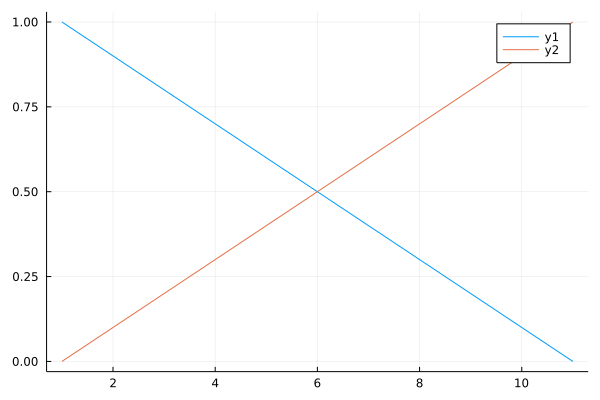

In [52]:
plot( [λ[s][1] for s in eachindex(λ)] )
plot!( [λ[s][2] for s in eachindex(λ)] )
#plot!( [λ[s][3] for s in eachindex(λ)] )

In [53]:
pᵣ = copy(p)
SPB.L = 256
for s in 1:Sₜ
    pᵣ[s] = sinkhorn_barycenter_separated(λ[s], α, b_₀, d₀, k, SPB, caches)
end

In [54]:
ΔL₁ = [ norm(p[s]-pᵣ[s],1) for s in 1:Sₜ ]

11-element Vector{Float64}:
 7.265813835584988e-6
 0.0004100540481336379
 6.379356637457877e-7
 2.1525807071461847e-6
 1.5628105001135312e-7
 1.6342373940462166e-7
 1.5628104039987455e-7
 2.1525807060742742e-6
 6.379356630042942e-7
 0.0004100540481337976
 7.26581383545337e-6

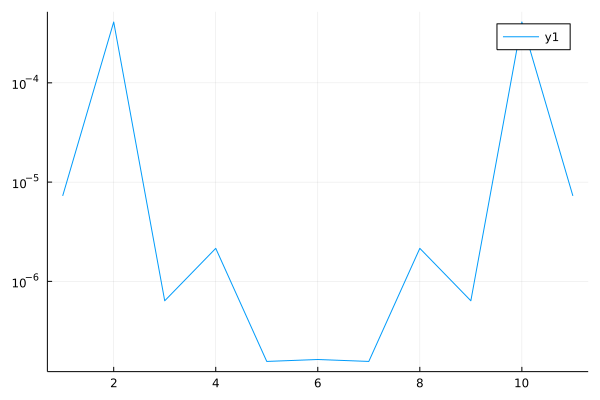

In [55]:
plot(ΔL₁, yaxis=:log)

In [56]:
sum(ΔL₁)./Sₜ, sum(ΔW)./Sₜ 

(7.642697659166001e-5, 1.715669163666894e-10)

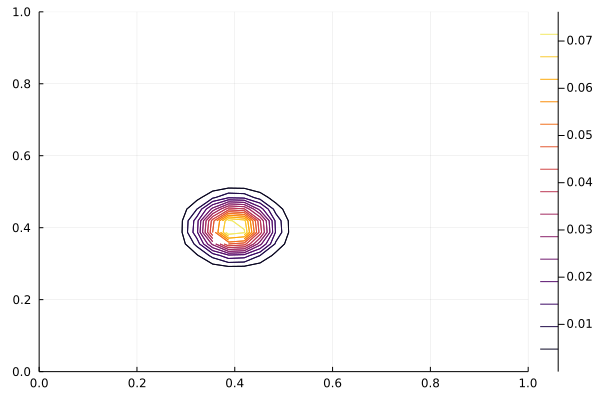

In [57]:
s_ = 4
contour(x₁, x₂, [p[s_], pᵣ[s_] ])

# SVD

In [40]:
Snap = zeros(n^2,Sₜ)

for s in 1:Sₜ
    Snap[:,s] .= reshape(p[s],n^2)
end

F = svd(Snap);

In [71]:
fieldnames(typeof(F))

(:U, :S, :Vt)

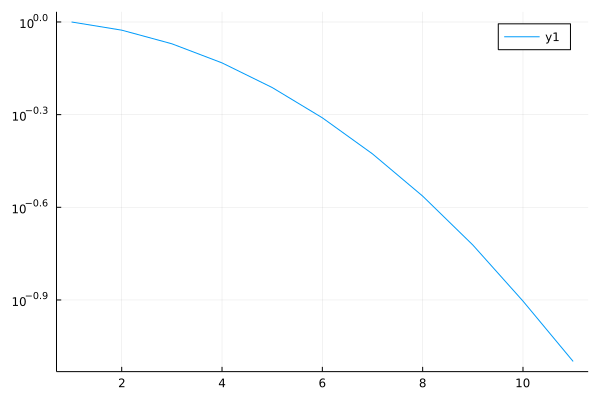

In [72]:
plot(F.S./F.S[1], yaxis = :log)

In [73]:
modes = [ reshape(F.U[:,s], (n,n)) for s in 1:Sₜ  ];

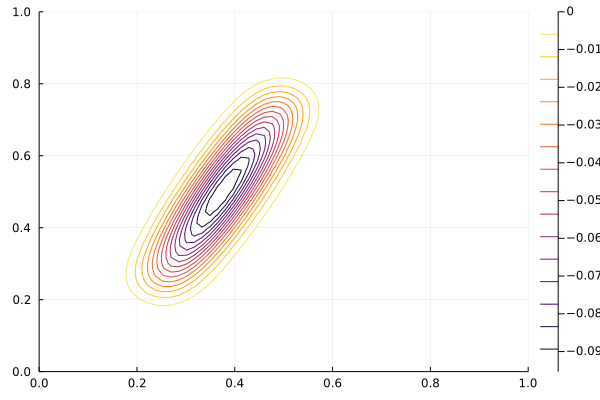

In [74]:
contour(x₁, x₁, modes[1])

In [75]:
Π = F.U[:,1:5] * F.U[:,1:5]';

In [92]:
pₛᵥ = [ reshape( Π * Snap[:,s], (n,n)) for s in 1:Sₜ ];

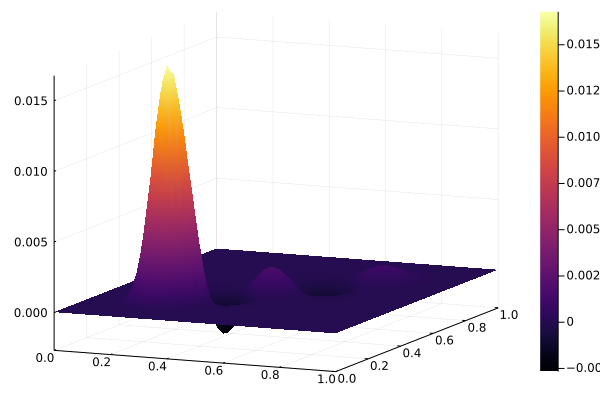

In [93]:
surface(x₁, x₁, pₛᵥ[1])

In [94]:
ΔL₁_svd = [ norm(p[s]-pₛᵥ[s],1) for s in 1:Sₜ ]

11-element Vector{Float64}:
 0.6661186934521615
 0.6870697228743186
 0.5511115797704018
 0.7123252778110214
 0.5809887365469859
 0.6889714733235554
 0.5887313779915846
 0.6010613422435769
 0.7084918310407196
 0.47036660182845824
 0.900915067762363